In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# 이미지 증각 객체 작성
gen = ImageDataGenerator(rotation_range = 15,
                         width_shift_range = 0.3,
                         shear_range=0.1,
                         rescale=1./255)

In [57]:
# 증강 이미지 적용 및 실생
data_path = 'drive/MyDrive/flower_photos'
batch_siz = 2313

data_gen = gen.flow_from_directory(directory=data_path,
                                   batch_size=batch_siz,
                                   shuffle=True,
                                   target_size=(100, 100),
                                   class_mode='categorical')

Found 2313 images belonging to 5 classes.


In [58]:
img, label = data_gen.next()
print(len(img))

2313


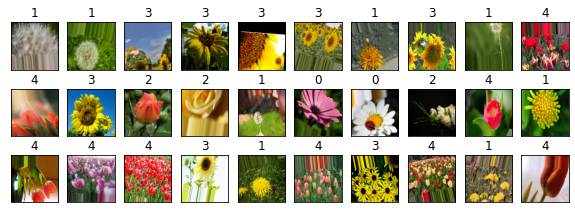

In [59]:
plt.figure(figsize=(10, 12))
for i in range(30):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(label[i])))
    plt.imshow(img[i])

In [60]:
result = []
for i in range(2313):
    result.append(np.argmax(label[i]))
result = np.array(result).reshape(-1, 1)
result.shape

(2313, 1)

In [61]:
x_train, x_test, t_train, t_test = train_test_split(img, result, test_size=0.3,
shuffle=False, random_state=1004)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('t_train shape:', t_train.shape)
print('t_test shape:', t_test.shape)

x_train shape: (1619, 100, 100, 3)
x_test shape: (694, 100, 100, 3)
t_train shape: (1619, 1)
t_test shape: (694, 1)


In [63]:
cnn = Sequential()
cnn.add(Conv2D(input_shape=(100, 100, 3), kernel_size=(3, 3), padding='same', filters=32, activation='relu')) # cnn.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
cnn.add(Conv2D(kernel_size=(3, 3), filters=32, padding='same', activation='relu')) # cnn.add(Conv2D(32,(3,3), activation='relu', padding='same'))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(kernel_size=(3, 3), filters=64, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3, 3), filters=64, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

# cnn.add(Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

# cnn.add(Conv2D(kernel_size=(3, 3), filters=256, padding='same', activation='relu'))
# cnn.add(MaxPool2D(pool_size=(2, 2)))
# cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 conv2d_32 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 50, 64)        36928     
                                                      

In [64]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 손실함수가 5 epochs을 진행을 검사하여 더이상 줄어들지 않으면 종료
# EarlyStopping(모니터링 값, 대기 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 학습 중인 모델을 자동 저장
model_checkpoint = ModelCheckpoint(filepath='bast.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

hist = cnn.fit(x_train, t_train, batch_size=256, epochs=50, validation_data=(x_test, t_test), callbacks=[early_stopping, model_checkpoint])

end_time = datetime.now()
print(end_time-start_time)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.9092 - accuracy: 0.1952
Epoch 1: val_loss improved from inf to 1.74550, saving model to bast.h5
7/7 [==============================] - 3s 266ms/step - loss: 1.9092 - accuracy: 0.1952 - val_loss: 1.7455 - val_accuracy: 0.2493
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.6892 - accuracy: 0.2841
Epoch 2: val_loss improved from 1.74550 to 1.56626, saving model to bast.h5
7/7 [==============================] - 2s 228ms/step - loss: 1.6892 - accuracy: 0.2841 - val_loss: 1.5663 - val_accuracy: 0.3473
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 1.4842 - accuracy: 0.3626
Epoch 3: val_loss improved from 1.56626 to 1.33013, saving model to bast.h5
7/7 [==============================] - 2s 226ms/step - loss: 1.4842 - accuracy: 0.3626 - val_loss: 1.3301 - val_accuracy: 0.4352
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 1.2952 - accuracy: 0.4546
Epoch 4: val_loss imp

In [65]:
cnn.evaluate(x_test, t_test)

22/22 [==============================] - 0s 11ms/step - loss: 0.9852 - accuracy: 0.7190


[0.9851864576339722, 0.7190201878547668]

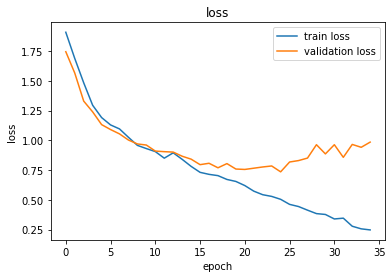

In [66]:
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

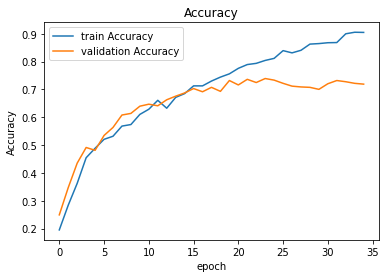

In [67]:
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'], label='train Accuracy')
plt.plot(hist.history['val_accuracy'], label='validation Accuracy')
plt.legend(loc='best')

In [68]:
t_test = tf.keras.utils.to_categorical(t_test, num_classes=5)

In [69]:
predictions=cnn.predict(x_test)

22/22 [==============================] - 0s 9ms/step


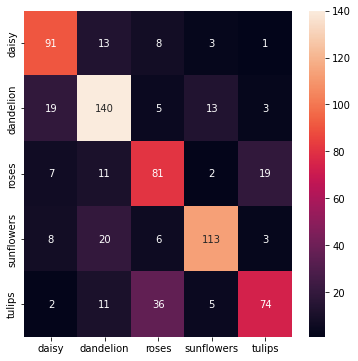

In [70]:
map = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
plt.figure(figsize=(6, 6))
cm = confusion_matrix(np.argmax(t_test, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=map, yticklabels=map)

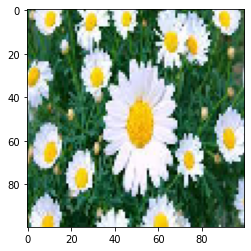

In [81]:
img_path = 'drive/MyDrive/data/daisy.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [82]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 17ms/step
daisy


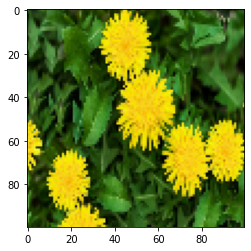

In [83]:
img_path = 'drive/MyDrive/data/dandelion.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [84]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 21ms/step
sunflowers


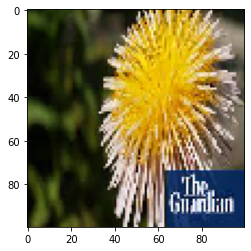

In [85]:
img_path = 'drive/MyDrive/data/dandelion2.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [86]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 18ms/step
daisy


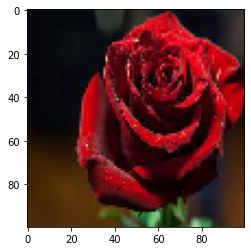

In [87]:
img_path = 'drive/MyDrive/data/roses.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [88]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 16ms/step
roses


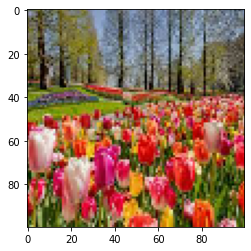

In [79]:
img_path = 'drive/MyDrive/data/tulips.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [80]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 16ms/step
roses


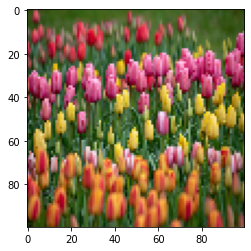

In [89]:
img_path = 'drive/MyDrive/data/tulips2.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [90]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 16ms/step
roses


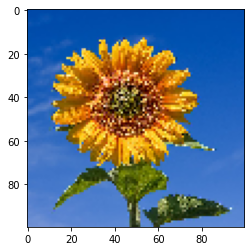

In [91]:
img_path = 'drive/MyDrive/data/sunflower.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [92]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(map[np.argmax(cnn.predict(img_batch))])

1/1 [==============================] - 0s 18ms/step
sunflowers
